In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os

In [2]:
IMAGE_SIZE = 200
BATCH_SIZE = 32
CHANNELS = 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage", 
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE

)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

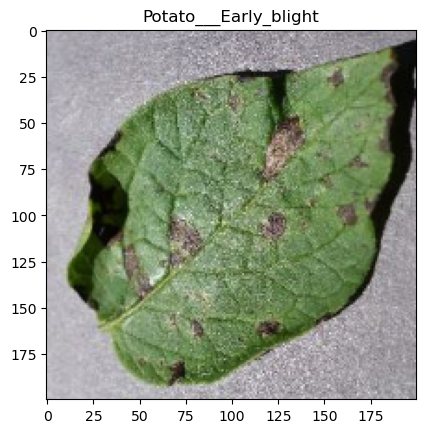

In [6]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.title(class_names[label_batch[0]])

In [7]:
def partition_dataset(data, train = 0.8, test = 0.1, val = 0.1):
    ds_size = len(data)
    train_size = int(ds_size * train)
    test_size = int(ds_size * test)
    val_size = int(ds_size * val)
    
    train = data.take(train_size)
    val = data.skip(train_size).take(val_size)
    test = data.skip(train_size).skip(val_size)
    return train,test,val

In [8]:
train_ds,test_ds,val_ds = partition_dataset(dataset)

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [10]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [11]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

## Model

In [12]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 200, 200, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 198, 198, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 99, 99, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 97, 97, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 48, 48, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 46, 46, 64)         

In [14]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [15]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=25,
)

Epoch 1/25
54/54 [==============================] - 53s 916ms/step - loss: 0.9229 - accuracy: 0.4497 - val_loss: 0.8790 - val_accuracy: 0.5052
Epoch 2/25
54/54 [==============================] - 43s 801ms/step - loss: 0.7513 - accuracy: 0.6493 - val_loss: 0.5433 - val_accuracy: 0.7552
Epoch 3/25
54/54 [==============================] - 39s 728ms/step - loss: 0.5017 - accuracy: 0.7708 - val_loss: 0.4729 - val_accuracy: 0.8073
Epoch 4/25
54/54 [==============================] - 39s 716ms/step - loss: 0.3896 - accuracy: 0.8374 - val_loss: 0.3038 - val_accuracy: 0.8698
Epoch 5/25
54/54 [==============================] - 42s 783ms/step - loss: 0.2911 - accuracy: 0.8883 - val_loss: 0.3638 - val_accuracy: 0.8646
Epoch 6/25
54/54 [==============================] - 40s 746ms/step - loss: 0.3222 - accuracy: 0.8611 - val_loss: 0.2207 - val_accuracy: 0.9271
Epoch 7/25
54/54 [==============================] - 40s 745ms/step - loss: 0.2095 - accuracy: 0.9161 - val_loss: 0.1459 - val_accuracy: 0.9531

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [17]:
EPOCHS = 25

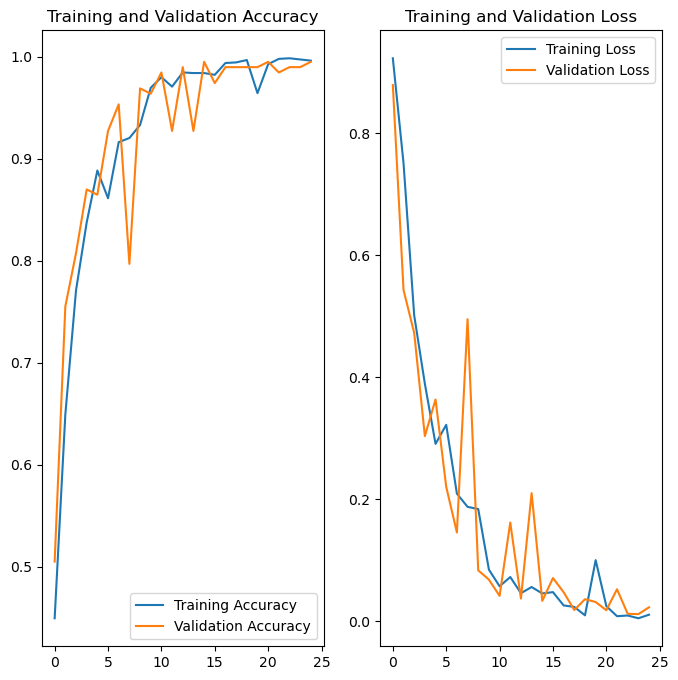

In [18]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## prediction

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 1s 624ms/step
predicted label: Potato___Late_blight


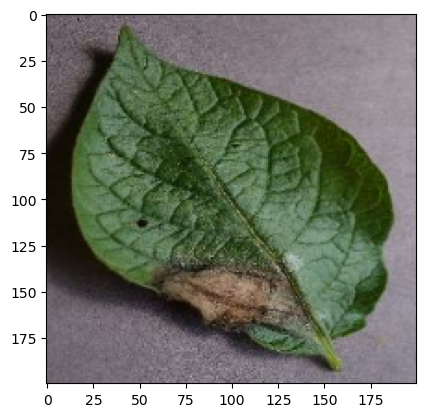

In [19]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [20]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 76ms/step


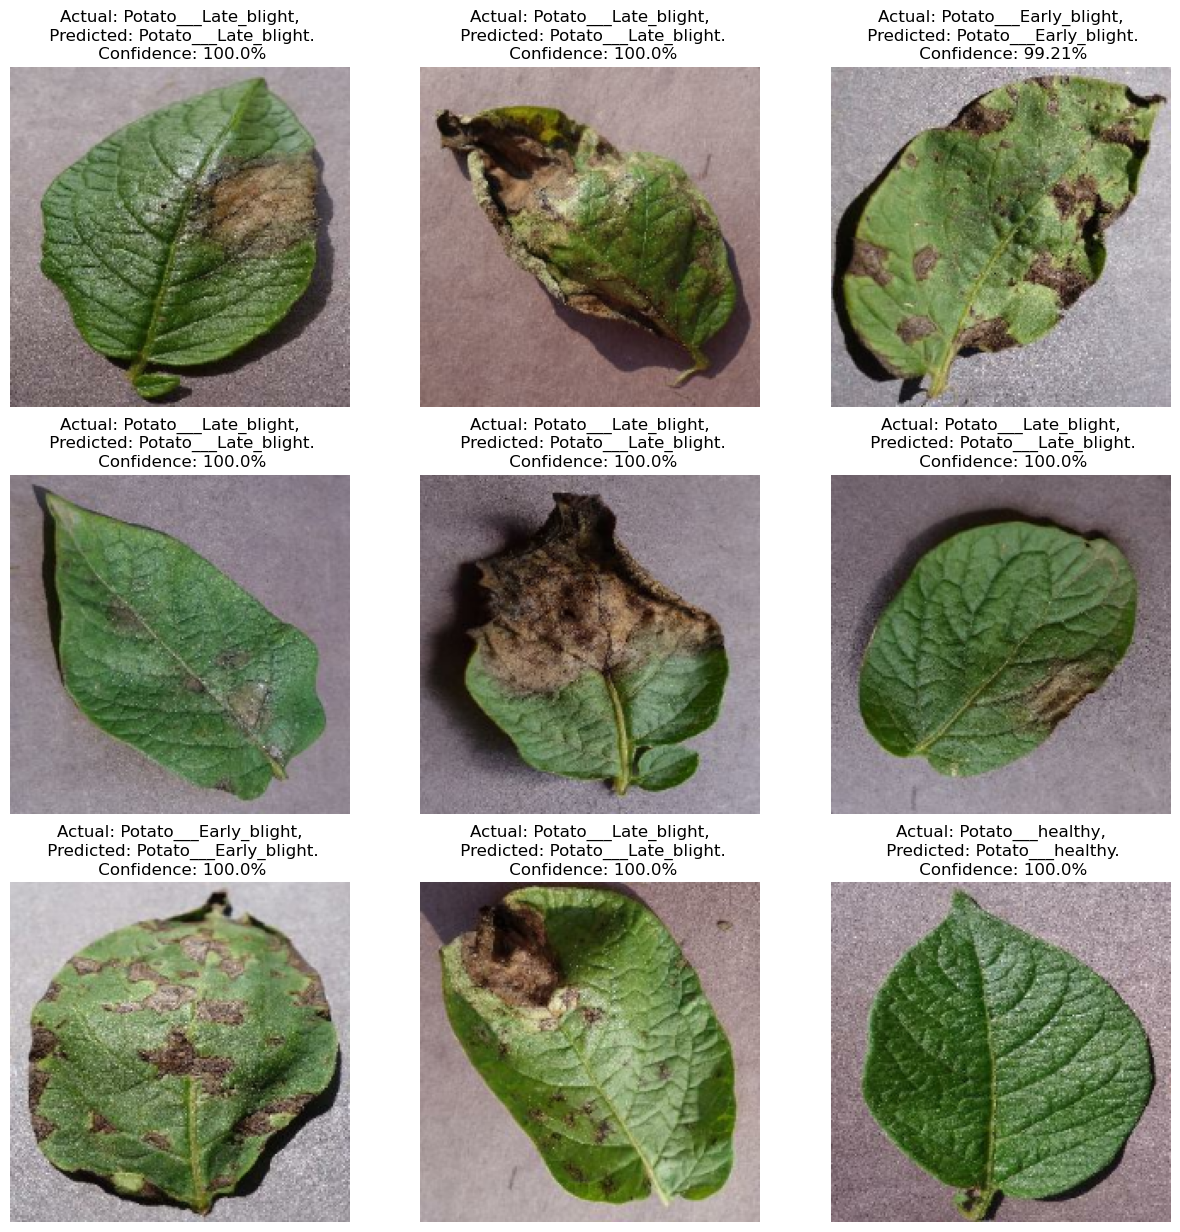

In [21]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [22]:
directory = 'model'
if not os.path.exists(directory):
    os.makedirs(directory)

# Save the model to the 'model' directory
model.save(os.path.join(directory, 'my_model'))

INFO:tensorflow:Assets written to: model\my_model\assets


INFO:tensorflow:Assets written to: model\my_model\assets


In [23]:
os.listdir("./model")

['my_model']

In [38]:
from PIL import Image

In [117]:
loaded_model = tf.keras.models.load_model("C:\\Users\\AjayKrishnan\\OneDrive - ADA Global\\Desktop\\neural net\\dlproject\\model\\my_model")

In [118]:
path = "C:\\Users\\AjayKrishnan\\OneDrive - ADA Global\\Desktop\\neural net\\dlproject\\PlantVillage\\Potato___Early_blight\\00d8f10f-5038-4e0f-bb58-0b885ddc0cc5___RS_Early.B 8722.JPG"

In [119]:
path2 = r"C:\Users\AjayKrishnan\OneDrive - ADA Global\Desktop\neural net\dlproject\PlantVillage\Potato___healthy\0be9d721-82f5-42c3-b535-7494afe01dbe___RS_HL 1814.JPG"

In [120]:
path3 = r"C:\Users\AjayKrishnan\OneDrive - ADA Global\Desktop\neural net\dlproject\PlantVillage\Potato___Late_blight\3a0033d6-2efc-4926-a9eb-3969d815d630___RS_LB 5144.JPG"

In [121]:
def predict_function(path,model):
    im = Image.open(path) 
    im = im.resize((200, 200), Image.LANCZOS)
    im = np.array(im)
    im_input = np.expand_dims(im, 0)
    pred  = loaded_model.predict(im_input)
    result =  np.argmax(pred)
    if result == 0:
        return("Potato___Early_blight")
    elif result == 1:
        return("Potato___Late_blight")
    else:
        return("Potato___healthy")

In [122]:
# ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [123]:
print(predict_function(path, loaded_model))

1/1 [==============================] - 0s 220ms/step
Potato___Early_blight


In [124]:
print(predict_function(path2, loaded_model))

1/1 [==============================] - 0s 63ms/step
Potato___healthy


In [125]:
print(predict_function(path3, loaded_model))

1/1 [==============================] - 0s 63ms/step
Potato___Late_blight


In [133]:
loaded_model.save('my_model.h5')  # Save as an HDF5 file


C:\Users\AjayKrishnan\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [134]:
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model('my_model.h5')